# EDC 3: Ekimetrics - AI for Sustainability
**Hypothèses:** 
- TO des camions
- Routes les plus empruntées => plot sur une map

**DataViz:** 
- Chloropleth 
- Plot Warehouses

In [1]:
# Set full width on jupyter notebook navigator
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np

sns.set_style('ticks')
pd.set_option('display.max_columns', 500) #display all the columns of a dataframe when doing df.head()

### Codecarbon 
Track the impact of our pipeline thanks to this [package](https://github.com/mlco2/codecarbon)

## Import data

In [3]:
cities = pd.read_csv("data/cities.csv")
factors = pd.read_csv("data/factors.csv")
orders = pd.read_csv("data/orders.csv")
packages = pd.read_csv("data/packages.csv")
pricing = pd.read_csv("data/pricing.csv")
routes = pd.read_csv("data/routes.csv")
trucks = pd.read_csv("data/trucks.csv")
warehouses = pd.read_csv("data/warehouses.csv")

In [4]:
cities.head(2)

city      lat     lng country iso2                  admin_name  capital  \
0  Paris  48.8566  2.3522  France   FR               Île-de-France  primary   
1   Nice  43.7034  7.2663  France   FR  Provence-Alpes-Côte d’Azur    minor   

   population  population_proper  is_warehouse  
0  11020000.0          2148271.0         False  
1   1006402.0           341032.0         False

In [5]:
factors = factors.set_index('name')
factors

value  comment
name                           
truck_volume     81.25      NaN
fuel_per_km       0.30      NaN
cost_per_liter    1.15      NaN
average_speed   100.00      NaN

In [6]:
orders.head(2)

order_id              package_id  package_volume  \
0  EtPmaD3APj8aRNeSC3Yx7R  Z8722BWG8WfyrU3jeWsWGo          0.2732   
1  4X4RBUwTXGBMVWdEj8Gti4  4oxrPXkner2kvXqvLQiCXF          0.2384   

     delivery_location from_warehouse  order_date       delivered_date  \
0                 Nice        Avignon  2021-01-01  2021-01-04 00:00:00   
1  Issy-les-Moulineaux          Cergy  2021-01-01  2021-01-03 00:00:00   

   n_units  order_total_volume  
0     27.0              7.3764  
1     41.0              9.7744

In [7]:
orders.describe()

package_volume       n_units  order_total_volume
count    37332.000000  37332.000000        37332.000000
mean         0.535009     26.031474           12.836235
std          0.709539     12.546886           18.422764
min          0.002000      5.000000            0.010000
25%          0.007100     15.000000            0.198800
50%          0.212200     26.000000            4.177800
75%          0.820800     37.000000           17.371200
max          2.723400     48.000000           77.280000

In [8]:
packages.describe()

package_volume  package_price  package_revenues
count       50.000000      50.000000         46.000000
mean         2.799790     336.568400        232.002826
std         16.033718     499.404812       1382.156572
min          0.002000       5.000000          4.890000
25%          0.007125       5.000000         13.990000
50%          0.219100      98.170000         20.990000
75%          0.888150     341.562500         30.490000
max        113.800000    1882.330000       9401.280000

In [9]:
pricing

max_volume  pricing  comment
0       0.003     4.89      NaN
1       0.027    13.99      NaN
2       0.432    20.99      NaN
3       1.000    30.49      NaN
4       4.000    69.89      NaN
5      10.000    89.99      NaN

In [10]:
routes.head(2)

truck_id   duration  fill_volume  n_units  \
0  jehwGBpNg2rDLeKoYeiaLs   2.167136       5.9879     87.0   
1  XnzFnkALW3tLnzrdCVFyKH  23.230412       4.7060    190.0   

                                              orders  \
0    nK4iPf8nrGA9yivRH66ehS > jnsH9ndQ3UKcWSbb2UMkFn   
1  XHfAWaLxTFbo5UQwtd7CMz > Wd6rPc4wPRNmt3ruf3F7o...   

                                               stops  total_distance  \
0                         Clermont-Ferrand > Bourges      153.950611   
1  Cergy > Saint-Nazaire > Saint-Denis > Rouen > ...     1416.184102   

     from_warehouse  route_date  
0  Clermont-Ferrand  2021-01-02  
1             Cergy  2021-01-02

In [11]:
trucks.head(2)

truck_id   truck_warehouse  truck_volume
0  hnxWnBLHwfeFX4Pz5smUN6  Clermont-Ferrand         81.25
1  mVUb5dkxfaSPBMKEujjeMg  Clermont-Ferrand         81.25

In [76]:
trucks.groupby('truck_warehouse').agg({'truck_id':'nunique'})

truck_id
truck_warehouse           
Avignon                 50
Cergy                   50
Clermont-Ferrand        50
Montauban               50
Reims                   50

In [12]:
warehouses

warehouse_city
0  Clermont-Ferrand
1             Cergy
2             Reims
3           Avignon
4         Montauban

## Traitement des données
- Missing values
- Wrong values (Courbevoic au lieu de Courbevoie)
- Issue with the 'aBCDNfWx5TAkxbTTmQJEE4' package - package_volume = 113.8 mismatch in `packages` and package_volume = 0.1138 `order`
- 4 missing values in `packages.package_revenues`
- remplace missing distance with average speed

#### 1- Cleaning routes

In [13]:
routes_cleaned = routes.copy()
routes_cleaned.stops = routes.apply(lambda x: x.stops.split(' > '), axis=1)
routes_cleaned.orders = routes.apply(lambda x: x.orders.split(' > '), axis=1)
routes_cleaned.head(1)

truck_id  duration  fill_volume  n_units  \
0  jehwGBpNg2rDLeKoYeiaLs  2.167136       5.9879     87.0   

                                             orders  \
0  [nK4iPf8nrGA9yivRH66ehS, jnsH9ndQ3UKcWSbb2UMkFn]   

                         stops  total_distance    from_warehouse  route_date  
0  [Clermont-Ferrand, Bourges]      153.950611  Clermont-Ferrand  2021-01-02

In [14]:
#Filling with average speed for 0 distance
routes_cleaned['total_distance']=routes_cleaned.apply(lambda x: x.duration*100 if x.total_distance == 0 else x.total_distance, axis=1)
#Filling with average speed for over 120*duration distance
routes_cleaned['total_distance'] = routes_cleaned.apply(lambda x: x.duration*100  if  x.total_distance > x.duration*120 else x.total_distance, axis=1 )

#### 2- Cleaning packages

In [15]:
packages[packages['package_volume']>10]

package_id  package_volume  package_price  package_revenues
28  aBCDNfWx5TAkxbTTmQJEE4           113.8         209.75             20.99

In [16]:
orders[orders['package_id']=='aBCDNfWx5TAkxbTTmQJEE4'].head(1)

order_id              package_id  package_volume  \
6  UeVqLAt9h6sfuB9AwC3iwD  aBCDNfWx5TAkxbTTmQJEE4          0.1138   

  delivery_location from_warehouse  order_date       delivered_date  n_units  \
6          Beauvais          Cergy  2021-01-01  2021-01-04 00:00:00     47.0   

   order_total_volume  
6              5.3486

In [17]:
packages[packages["package_revenues"]!=packages["package_revenues"]]

package_id  package_volume  package_price  package_revenues
11  khHNUxYZUEEiRkaVe2FyXg          2.0028        1366.11               NaN
15  mnEb7xGXa9dFMLPAkrZZoh          1.4152        1084.50               NaN
39  4oxrPXkner2kvXqvLQiCXF          0.2384           5.00               NaN
45  BewerkQGyB5yToxS4jhRpb          0.0754           5.00               NaN

In [18]:
packages[packages['package_revenues']>89.99]

package_id  package_volume  package_price  package_revenues
36  bfvaknKja6jMJYp56vtjgf          0.0072            5.0           9401.28

In [19]:
packages_cleaned = packages.copy()

#On commence par corriger la valeur du package de volume buggé
packages_cleaned.loc[packages_cleaned['package_id']=='aBCDNfWx5TAkxbTTmQJEE4','package_volume'] = 0.1138

#On corrige tous les prix pour les accorder au pricing selon le volume - tient compte des missing values en price
packages_cleaned['threshold'] = packages_cleaned.apply(lambda x: min(pricing.max_volume.values, key=lambda y:max(0,x.package_volume-y)) ,axis=1)

packages_cleaned = pd.merge(packages_cleaned,pricing[['max_volume','pricing']], left_on='threshold', right_on='max_volume')
packages_cleaned.loc[packages_cleaned['package_revenues']!=packages_cleaned['pricing'],'package_revenues'] = packages_cleaned['pricing']

#On ne garde que les colonnes pertinentes
packages_cleaned = packages_cleaned[packages.columns]

#### 3 - Cleaning order

## Questions répondues par la data:

#### 1 - Quels sont les endroits les plus livrés ? 

In [20]:
pck_volume_per_city = orders.groupby('delivery_location').aggregate({'package_volume':'sum'}).sort_values('package_volume',ascending=False)
pck_volume_per_city.head(5)

package_volume
delivery_location                
Boulogne-sur-Mer         230.7196
Le Mans                  229.7817
La Rochelle              229.4900
Tourcoing                226.9872
Courbevoic               225.7096

In [21]:
from urllib.request import urlopen
import json
import geopandas as gpd

with urlopen('https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson') as response:
    french_counties = json.load(response)
    geo_data = pd.DataFrame(gpd.GeoDataFrame(french_counties['features'])['properties'].tolist())
    geo_data['value']= 1

In [142]:
import plotly.graph_objects as go

pck_volume_per_city = orders.groupby('delivery_location').aggregate({'package_volume':'sum'}).sort_values('package_volume',ascending=False)
pck_volume_per_city = pd.merge(cities,pck_volume_per_city, left_on='city', right_index=True)

pck_volume_per_city['text'] = pck_volume_per_city['city'] + ', ' + 'Package_Volume: ' + round(pck_volume_per_city['package_volume']).astype(str)

trace0 = go.Choropleth(
    locations=geo_data['code'],
    geojson=french_counties,
    autocolorscale=False,
    z=geo_data['value'],
    featureidkey='properties.code', 
    showscale=False,
    showlegend=False,
    marker_line_color='grey',
    colorscale=[[0, "rgb(255,255,255)"],
                [1, "rgb(240,240,240)"]])

trace1 = data=go.Scattergeo(
        lon = pck_volume_per_city['lng'],
        lat = pck_volume_per_city['lat'],
        mode = 'markers',
        geojson= french_counties,
        text = pck_volume_per_city['text'],
        marker_color = pck_volume_per_city['package_volume'],
        marker = dict(
            size = 6,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            #symbol = 'square',
            line = dict(width=1,
                        color='rgba(102, 102, 102)'),
            colorscale = 'Reds',
            cmin = 150,
            color = pck_volume_per_city['package_volume'],
            cmax = pck_volume_per_city['package_volume'].max(),
            colorbar_title="Package Volume delivered<br>"),
        showlegend=False)

trace2 = data=go.Scattergeo(
        lon = cities[cities['is_warehouse'] == True]['lng'],
        lat = cities[cities['is_warehouse'] == True]['lat'],
        mode = 'markers',
        showlegend=False,
        marker = dict(
            size = 12,
            color = 'grey'))

fig = go.Figure(data=[trace0,
                      trace2,
                      trace1,
                     ])

fig.update_geos(fitbounds="locations", 
                visible=False,
                landcolor = "rgb(240, 240, 240)",)

fig.update_layout(
        title = 'Most delivered city in France by LPD',
        geo_scope='europe',
        margin=dict(l=10, r=10, t=45, b=20),
    )

fig.show()

#### 2-Les routes les plus empruntées

In [23]:
used_tracks = []
for i in range(len(routes_cleaned)):
    for j in range(len(routes_cleaned.stops[i])-1):
        used_tracks += [[routes_cleaned.stops[i][j] + ' - ' + routes_cleaned.stops[i][j+1],
                         routes_cleaned.stops[i][j],
                         routes_cleaned.stops[i][j+1],
                         routes_cleaned.route_date[i]]]
used_tracks = (pd.DataFrame(used_tracks,columns=['routes','start','stop','date']))

In [24]:
routes_used_per_day = (used_tracks
                       .groupby(['routes','date','start','stop'])
                       .agg({'routes':'count'})
                       .rename(columns={'routes':'nb_routes'})
                       .sort_values("nb_routes"))

routes_used_per_day = routes_used_per_day.reset_index()

In [25]:
routes_used = (routes_used_per_day
               .groupby(['routes','start','stop'])
               .agg({'routes':'count'})
               .rename(columns={'routes':'nb_routes'})
               .sort_values("nb_routes"))

routes_used = pd.merge(routes_used.reset_index(), cities[['city','lat','lng']], 
                       left_on='start',right_on='city')

routes_used = (routes_used
               .rename(columns={'lat':'lat_start','lng':'lng_start'})
               .drop(columns=['city']))

routes_used = pd.merge(routes_used.reset_index(), cities[['city','lat','lng']], 
                       left_on='stop',right_on='city')

routes_used = (routes_used
               .rename(columns={'lat':'lat_stop','lng':'lng_stop'})
               .drop(columns=['city']))

routes_used.head()

index                             routes             start            stop  \
0      0  Levallois-Perret - Ivry-sur-Seine  Levallois-Perret  Ivry-sur-Seine   
1     88   Le Blanc-Mesnil - Ivry-sur-Seine   Le Blanc-Mesnil  Ivry-sur-Seine   
2    213          Le Havre - Ivry-sur-Seine          Le Havre  Ivry-sur-Seine   
3    269           Le Mans - Ivry-sur-Seine           Le Mans  Ivry-sur-Seine   
4    388             Cergy - Ivry-sur-Seine             Cergy  Ivry-sur-Seine   

   nb_routes  lat_start  lng_start  lat_stop  lng_stop  
0          1    48.8950     2.2872   48.8078    2.3747  
1         67    48.9387     2.4614   48.8078    2.3747  
2         14    49.4900     0.1000   48.8078    2.3747  
3          3    48.0077     0.1984   48.8078    2.3747  
4         69    49.0361     2.0631   48.8078    2.3747

In [138]:
import plotly.graph_objects as go

pck_volume_per_city = orders.groupby('delivery_location').aggregate({'package_volume':'sum'}).sort_values('package_volume',ascending=False)
pck_volume_per_city = pd.merge(cities,pck_volume_per_city, left_on='city', right_index=True)

pck_volume_per_city['text'] = pck_volume_per_city['city'] + ', ' + 'Package_Volume: ' + round(pck_volume_per_city['package_volume']).astype(str)

trace = go.Choropleth(
    locations=geo_data['code'],
    geojson=french_counties,
    autocolorscale=False,
    z=geo_data['value'],
    featureidkey='properties.code', 
    showscale=False,
    marker_line_color='grey',
    colorscale=[[0, "rgb(255,255,255)"],
                [1, "rgb(240,240,240)"]],
    showlegend=False)

fig = go.Figure(data=trace)

for i in range(len(routes_used)):
    fig.add_trace(go.Scattergeo(
                        lat = [routes_used.lat_start[i],routes_used.lat_stop[i]],
                        lon = [routes_used.lng_start[i],routes_used.lng_stop[i]],
                        mode = 'lines',
                        line = dict(width = routes_used.nb_routes[i]/50, color="grey"), 
                        showlegend=False
                        ))


fig.add_trace(go.Scattergeo(
        lon = pck_volume_per_city['lng'],
        lat = pck_volume_per_city['lat'],
        mode = 'markers',
        geojson= french_counties,
        text = pck_volume_per_city['text'],
        marker_color = pck_volume_per_city['package_volume'],
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(width=1,
                        color='rgba(102, 102, 102)'),
            colorscale = 'Reds',
            cmin = 150,
            color = pck_volume_per_city['package_volume'],
            cmax = pck_volume_per_city['package_volume'].max(),
            colorbar_title="Package Volume delivered<br>"),
        showlegend=False),
            )

fig.update_geos(fitbounds="locations", 
                visible=False,
                landcolor = "rgb(240, 240, 240)",)

fig.update_layout(
        title = 'Most used routes by LPD',
        geo_scope='europe',
        margin=dict(l=10, r=10, t=45, b=20),
    )

#### 3 - Taux de remplissage des camions

In [27]:
tr_trucks = pd.merge(routes_cleaned,trucks, right_on='truck_id', left_on='truck_id')
tr_trucks["fill_ratio"] = (tr_trucks['fill_volume'])/tr_trucks['truck_volume']

print("Le taux de remplissage total des camions est de: %.2f " % (tr_trucks["fill_ratio"].mean()*100) +'%')

Le taux de remplissage total des camions est de: 75.25 %


**Tension par warehouse**

In [82]:
tr_trucks.groupby("truck_warehouse").agg({"fill_ratio":'mean'}).sort_values('fill_ratio',ascending=False)

fill_ratio
truck_warehouse             
Cergy               0.770519
Reims               0.749822
Avignon             0.743516
Montauban           0.731426
Clermont-Ferrand    0.671110

#### 4- Différence par réseau

In [75]:
routes_cleaned.groupby("from_warehouse").agg({"duration":'mean',"total_distance":'mean','route_date':'count'}).sort_values('route_date',ascending=False)

duration  total_distance  route_date
from_warehouse                                        
Cergy             7.364373      356.604416        3746
Avignon           7.491808      385.404935        1345
Reims             8.486398      478.512079        1056
Montauban         8.149868      470.146834         854
Clermont-Ferrand  5.431847      223.789753         425

#### 5 - Costs

**Couts sur le base de la distance**

In [54]:
routes_cleaned['cost']=routes_cleaned.total_distance*factors.loc['fuel_per_km'].value*factors.loc['cost_per_liter'].value

In [55]:
routes_cleaned.groupby("from_warehouse").agg({"cost":'mean'}).sort_values('cost',ascending=False)

cost
from_warehouse              
Reims             165.086667
Montauban         162.200658
Avignon           132.964703
Cergy             123.028524
Clermont-Ferrand   77.207465

In [56]:
df = routes_cleaned.groupby("route_date").agg({"cost":'mean'}).sort_values('route_date',ascending=False).reset_index()
df.head()

route_date        cost
0  2021-06-29  131.221511
1  2021-06-28  116.245251
2  2021-06-27  118.647889
3  2021-06-26  103.948719
4  2021-06-25  112.343205

In [57]:
print("Le coût est de: %.2f " % (routes_cleaned['cost'].sum()) +'€')

Le coût est de: 985366.43 €


#### 6 - Revenues

In [35]:
orders_price = pd.merge(packages_cleaned[['package_id','package_volume','package_revenues']],
                        orders[['order_id','package_id','n_units']],
                        right_on='package_id',left_on='package_id')

orders_price['total_revenue']=orders_price['package_revenues']*orders_price['n_units']
orders_price.head()

package_id  package_volume  package_revenues  \
0  jjnvac3HYvsrBQp9jxf5qj          1.0615             69.89   
1  jjnvac3HYvsrBQp9jxf5qj          1.0615             69.89   
2  jjnvac3HYvsrBQp9jxf5qj          1.0615             69.89   
3  jjnvac3HYvsrBQp9jxf5qj          1.0615             69.89   
4  jjnvac3HYvsrBQp9jxf5qj          1.0615             69.89   

                 order_id  n_units  total_revenue  
0  dim6fxGFE2dZAyKAgUddhy     22.0        1537.58  
1  SK3ZHMGM4wbUeX7BHH4mxY     22.0        1537.58  
2  g7JvdYwzWEAu5Ad43s7zr8     13.0         908.57  
3  dbEMd37Z4Tx8upESHE4fo6     12.0         838.68  
4  ijCCjvhqZRmBvjPvuM58sM     24.0        1677.36

In [36]:
from tqdm import tqdm

revenue_per_order = []

for i in tqdm(range(len(routes_cleaned))):
    orders_per_route = []
    for order in routes_cleaned.orders[i]:
        
        orders_per_route += [float(orders_price.loc[orders_price['order_id']==order].total_revenue.values)]
    revenue_per_order += [sum(orders_per_route)]
    
revenue_per_order = pd.DataFrame(revenue_per_order,columns = ['revenue'])

100%|██████████| 7426/7426 [02:21<00:00, 52.64it/s]


In [83]:
routes_cleaned['revenue'] = revenue_per_order

print("Le revenue total est de: %.2f " % (routes_cleaned['revenue'].sum()) +'€')

Le revenue total est de: 26621998.22 €


In [92]:
(routes_cleaned.groupby("from_warehouse")
 .agg({"revenue":['sum','mean']})
 .sort_values([('revenue', 'sum')], ascending=False))

revenue             
                          sum         mean
from_warehouse                            
Cergy             13724703.76  3663.829087
Avignon            4788543.32  3560.255257
Reims              3772792.27  3572.719953
Montauban          2960617.51  3466.765234
Clermont-Ferrand   1375341.36  3236.097318

#### 7 - Temporalité

In [93]:
routes_cleaned.head(1)

truck_id  duration  fill_volume  n_units  \
0  jehwGBpNg2rDLeKoYeiaLs  2.167136       5.9879     87.0   

                                             orders  \
0  [nK4iPf8nrGA9yivRH66ehS, jnsH9ndQ3UKcWSbb2UMkFn]   

                         stops  total_distance    from_warehouse  route_date  \
0  [Clermont-Ferrand, Bourges]      153.950611  Clermont-Ferrand  2021-01-02   

        cost  revenue  
0  53.112961  1182.13

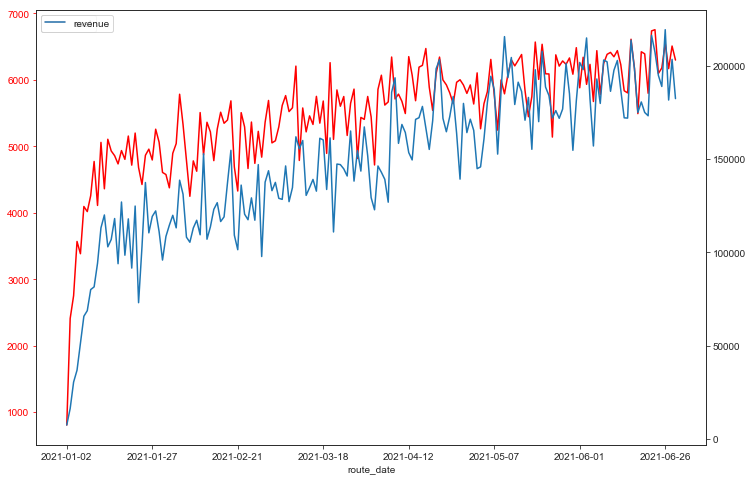

In [115]:
fig = plt.figure(1, (12,8))
ax = fig.add_subplot(1,1,1)

ax2 = ax.twinx()

routes_cleaned.groupby('route_date').agg({"cost":"sum"}).plot(ax=ax, color='red')
routes_cleaned.groupby('route_date').agg({"revenue":"sum"}).plot(ax=ax2);


ax.yaxis.label.set_color('red')
ax2.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='red')

## Références: 
[1] [Resilience and Vibrancy: The 2020 Data & AI Landscape](https://mattturck.com/data2020/), Matt Turck, September 30, 2020  
[2] [L’apprentissage automatique en images](http://www.r2d3.us/lapprentissage-automatique-en-images-chapitre-1/)  
[3] [Notion de l'EDC](https://nettle-search-8c3.notion.site/Guide-tude-de-cas-Ekimetrics-2021-f1bff84a4cbb45319f01a3fd603259ba)  
[4] [Tech Radar](https://ekimetrics.github.io/tech-radar/)  
[5] [Streamlit](https://streamlit.io/)